# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this project, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this project, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In [ ]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:04<00:00, 15.4MB/s]


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages) #fit_on_texts
  messages_seq = tokenizer.texts_to_sequences(messages) #text_to_sequences
  data = pad_sequences(messages_seq, maxlen=max_len) #pad_sequences


  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

function of "fit_on_texts" \\

`It updates the vocabulary of the integer-word indexing dictionary with words from an array of texts/strings <messages>, such that the words that had the highest frequency of occurance will have the smallest index, and the words with the lowest frequency will have the largest index.`

`ie. Tokenizer().fit_on_texts(["farmer farmer lies"])`

`    Tokenizer().word_index would return {"farmer":1, "lies":2}`

` Now imagine doing that exact functionality for <messages> which is an array with 60000 strings of reviews, each with a huge variety of words`


function of "texts_to_sequences" \\

`I think it converts a string of text ie) "hello world I am Lingjun" into a sequence of integers ie) [1, 23, 2, 3, 1000] based on each word's indexing in the dictionary.`

function of "pad_sequences" \\

`I think there are some reviews that do not meet the 200 word wordcount. In order for the sequences to have the same size of 200, they pad the missing words with 0's in the sequence to meet the 200 word wordcount. That is effectively what this function does: it pads the sequences in <messages_seq> with zeros until all sequences in <messages_seq> are of the length <max_len>.`

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

In [ ]:
print(messages_train[np.random.randint(0,40000,1)])

# Seems like training set has 40,000 reviews, each with a maximum length of 200 words.
# -> messages_train contains 40,000 arrays each with 200 elements.

[[  25  554    1  564   42   48  555   50  125  891  213    2    3  764
   173    4  125 1617 1205 1185  297    3   52  128   35    6   52    5
   385   48   28  487 1967   28  487    9   61   96  523   12    9  292
    48   28  862    2  110   24  366   28 1207   82    1  140    3    8
  1307    2    8  965  797   28  653   53   40   16    1    4   40   18
    59   80   25  619    4    9 1213    2   87   30  170  477    2    2
   676    2    7    7    1   19   45  711   60  811    9   45  573 1430
     2  460   15    1  254    2    3 1271  337   21    5    2  200   21
   354  314    8  346   38    1  223  284   10  287    1   19   13   84
    33   23 1485  150    2    1  223  220    4   11   17    6   12  501
    83   38   30  224 1485   83   35   25 1417    5  529   33  101   36
     1  181    7    7   43   22   67 1730    9   20   92  199 1296  474
   165    8   11 1915    2   19    2   14   73  302    6   48   44   29
    42  138    3   17   16  138    3  174   61  270  183  100   

# Embedding Layer



Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

In [ ]:
# start of my code

sentence = messages_train[0]
E = Embed(max_vocab, embedding_size)
embed_matrix = E.w #embed_matrix.shape == (2000, 30)

embedded_sentence = embed_matrix.value[sentence] #embedded_sentence.shape = (200,30)
print(embedded_sentence.shape)
print(embedded_sentence.shape[0])

a = embedded_sentence
# end of my code

(200, 30)
200


how `__init__` and `__call__` work?

`input is a sentence -> in the form of an array -> each element of the array is an integer -> integer represents the index-value of the non-zero index in the one-hot-encoded vector, used to represent each distinct word in the dictionary.`
`So, if input is a sentence -> assume that it is an sequence of length <max_len> similar to messages[i], such that each element is an integer in the interval {1...max_vocab}.`

`sentence = messages_train[0]`

`embed = Embed(max_vocab, embedding_size)`

`E = embed.w`

`inputNN = E.value[sentence]`


`How does __init__ function work: As we know from python classes, __init__ function defines the attributes and how to construct an instance of the class Embed ie) embed = Embed(max_vocab, embedding_size), where one of the attributes, E = embed.w is the embedding matrix, with <max_vocab> number of rows and <embedding_size> number of columns, which is used to convert one-hot encodings of words to their embedded versions. In the embedding matrix, each row x represents the embedded version of one-hot_x `

`How does __call__ function work: call function accesses a specific row x in the embed matrix E. So, given a one-hot vector O_x, we can get the embedded version e_x through e_x = E.value[x], given an JaxArray, it goes through all the elements inside it and does the same thing but globally across all elements.`

`Effectively, when you pass a sentence (sequence of integers) as an input into the embed layer, __init__ gives instructions on how to initialize the embed matrix (ie. number of rows&cols and how to define elementwise values), and __call__ is used to access the embedded version of each word (one-hot vector), whose location is the integer stored in the sequence elements that corresponds to a row in the embed matrix.'`

`__call__ is used to convert a sentence (sequence of integers representing one-hot-encoding indices) into a matrix that is a matrix of embedded words that correspond to the sentence.`

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this project, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

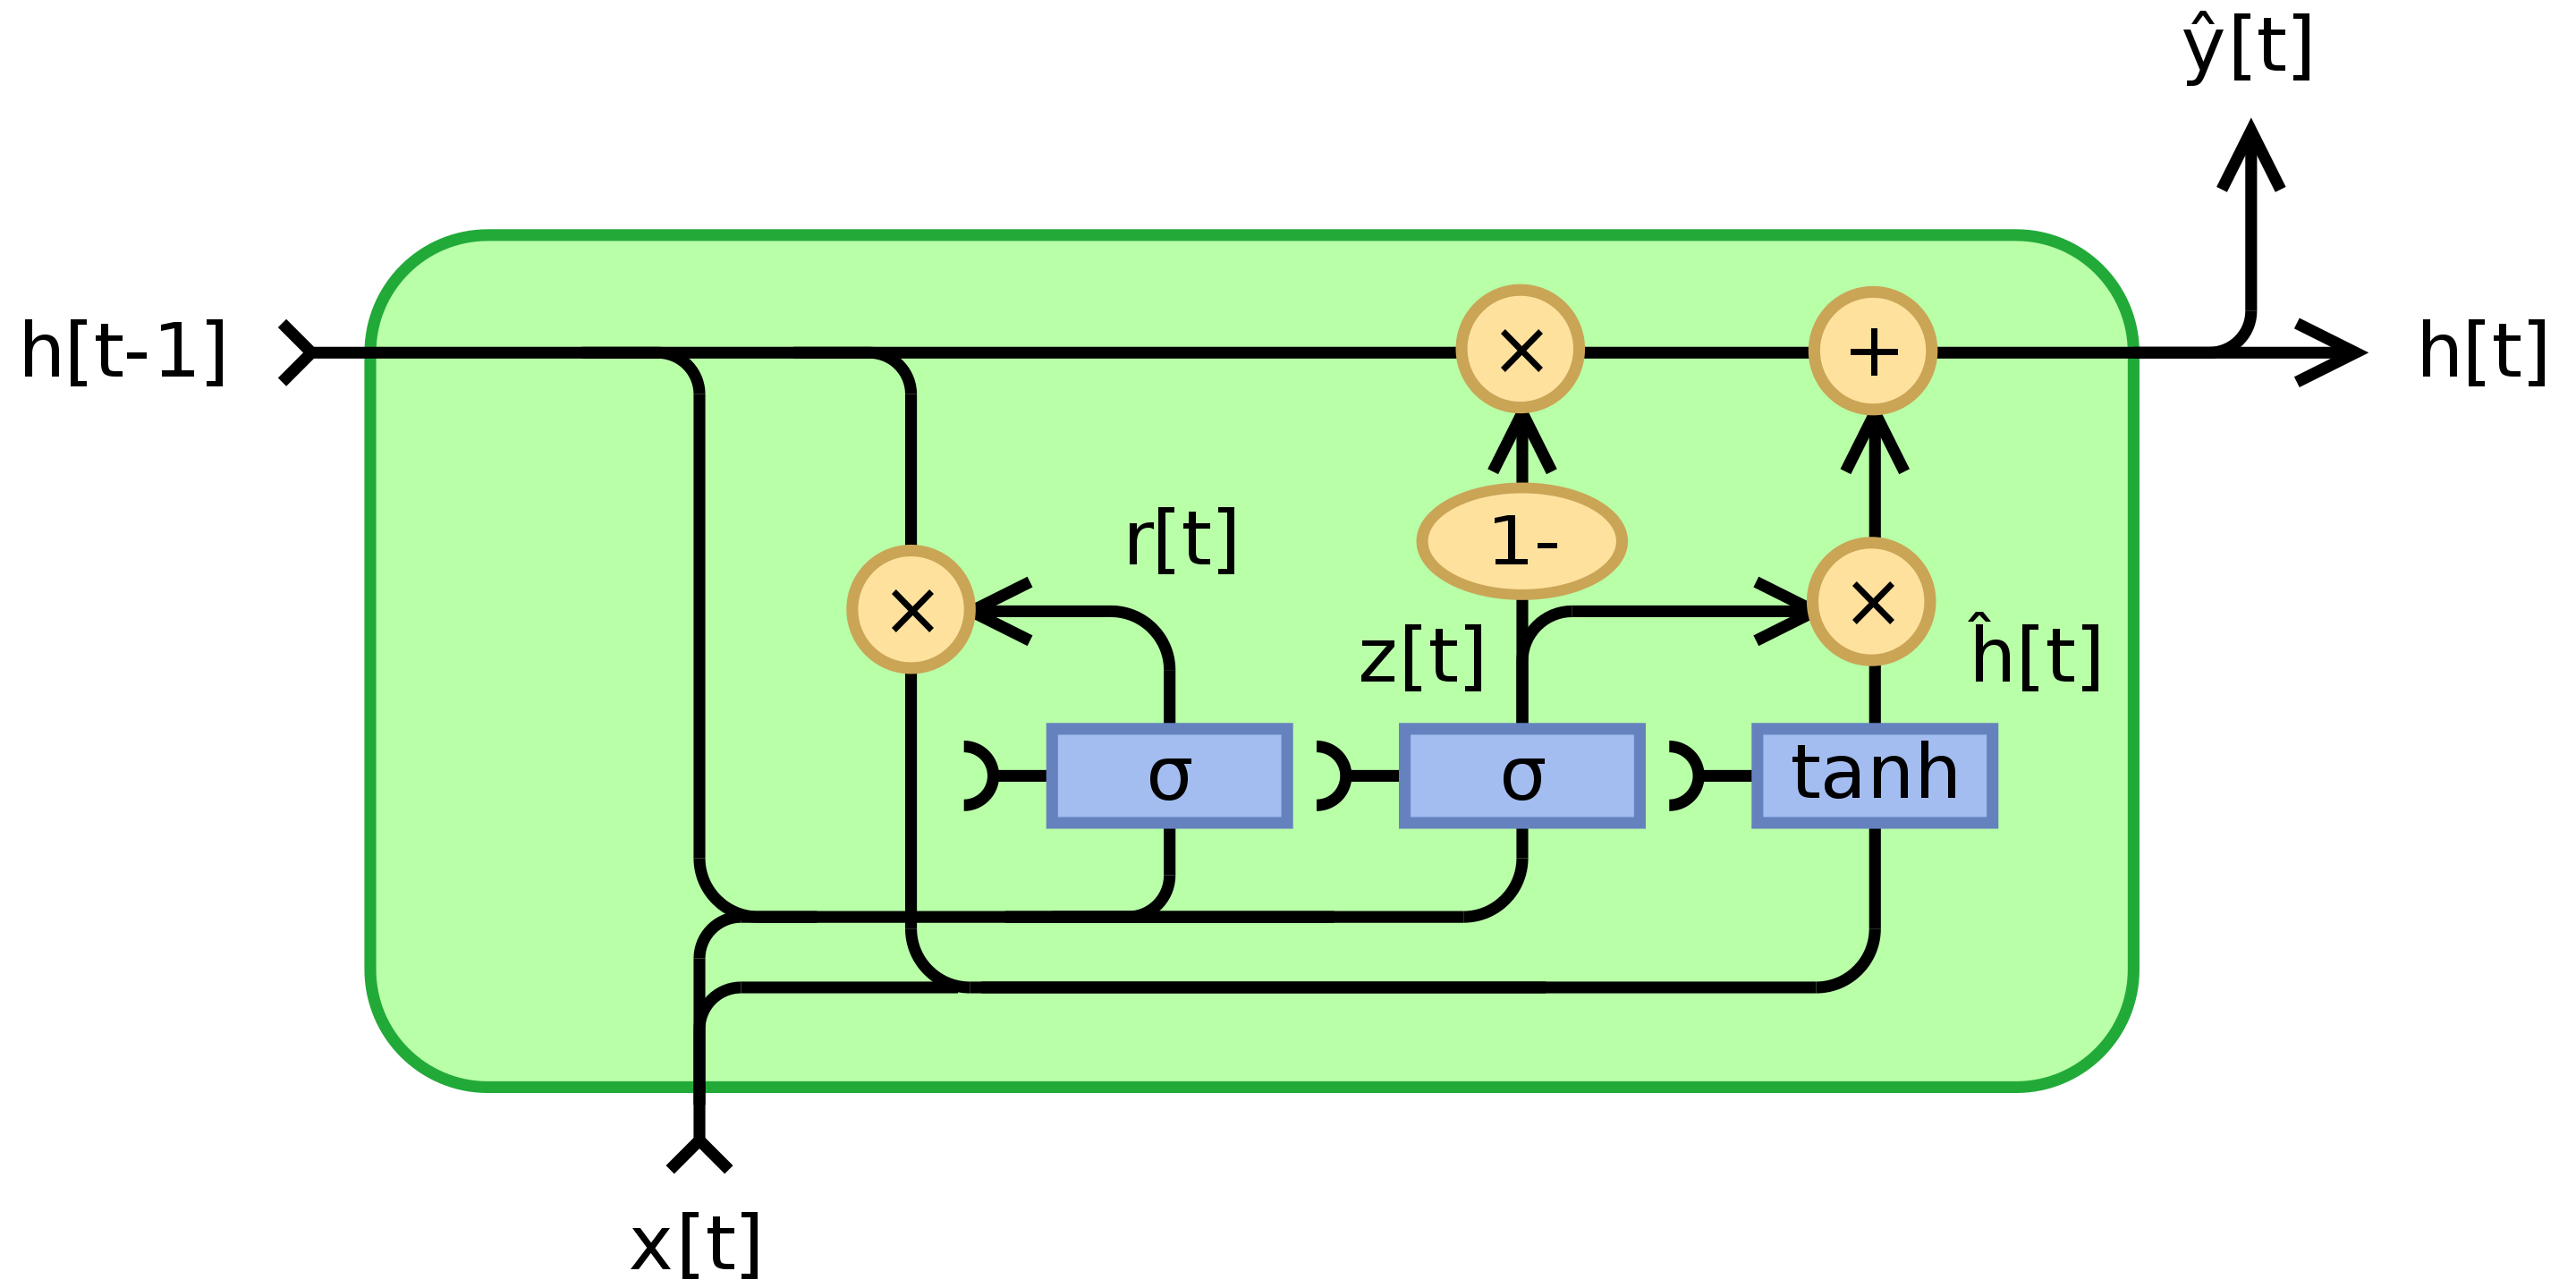

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Implementation of GRU unit**

In [ ]:
from objax.functional import sigmoid, tanh

class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
            def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
                # fill this in
                update_gate = sigmoid(jn.dot(x, self.update_w.value) + jn.dot(state, self.update_u.value) + self.update_b.value)

                # fill this in
                reset_gate = sigmoid(jn.dot(x, self.reset_w.value) + jn.dot(state, self.reset_u.value) + self.reset_b.value)
                
                # fill this in
                output_gate = tanh(jn.dot(x, self.output_w.value) + jn.dot(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value)
                
                #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
                return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

            return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



In [ ]:
gru_rnn = objax.nn.Sequential([
    Embed(max_vocab, embedding_size), 
    GRU(embedding_size, num_hidden_units_GRU), #could also be max_len for embedding_size
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])


Print of Structure of Neural Network

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


Optimizer Construction - using SGD from optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
# opt = objax.optimizer.SGD(gru_rnn.vars())
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:

def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

Training Loop

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:


BATCH = batch_size
LEARNING_RATE = learning_rate
train_acc_epoch = []
avg_train_loss_epoch = []

val_acc_epoch = []
avg_val_loss_epoch = []

for epoch in range(num_epochs):
    avg_train_loss = 0 # Average training loss per batch
    avg_val_loss = 0 # Average validation loss per batch
    train_acc = 0 # Training accuracy per batch
    val_acc = 0 # Validation accuracy per batch

    # Training
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], BATCH):
        batch = train_indices[it:it+BATCH]
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
        train_prediction = eval_op(messages_train[batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
    train_acc_epoch.append(train_acc/messages_train.shape[0])
    avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

    # Validation
    val_indices = np.arange(len(messages_valid)) 
    np.random.shuffle(val_indices)    
    for it in range(0, messages_valid.shape[0], BATCH):
        batch = val_indices[it:it+BATCH]
        avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
        val_prediction = eval_op(messages_valid[batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
    val_acc_epoch.append(val_acc/messages_valid.shape[0])
    avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

    print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' 
          % (epoch + 1, avg_train_loss/messages_train.shape[0], 
             avg_val_loss/messages_valid.shape[0], 
             100*train_acc/messages_train.shape[0], 
             100*val_acc/messages_valid.shape[0]))



Epoch 0001  Training Loss 172.68 Validation Loss 171.50 Training Accuracy 55.05 Validation Accuracy 56.74
Epoch 0002  Training Loss 168.77 Validation Loss 167.77 Training Accuracy 59.73 Validation Accuracy 57.20
Epoch 0003  Training Loss 163.32 Validation Loss 157.21 Training Accuracy 62.46 Validation Accuracy 62.34
Epoch 0004  Training Loss 156.19 Validation Loss 149.44 Training Accuracy 66.01 Validation Accuracy 67.44
Epoch 0005  Training Loss 149.54 Validation Loss 136.84 Training Accuracy 68.48 Validation Accuracy 72.66
Epoch 0006  Training Loss 147.82 Validation Loss 155.52 Training Accuracy 69.79 Validation Accuracy 64.78
Epoch 0007  Training Loss 143.26 Validation Loss 130.53 Training Accuracy 72.19 Validation Accuracy 73.98
Epoch 0008  Training Loss 138.89 Validation Loss 119.08 Training Accuracy 73.05 Validation Accuracy 77.46
Epoch 0009  Training Loss 137.83 Validation Loss 139.49 Training Accuracy 74.05 Validation Accuracy 72.74
Epoch 0010  Training Loss 133.95 Validation Lo

In [ ]:
avg_test_loss = float(loss_function(messages_test, labels_test)) * len(messages_test)
test_prediction = eval_op(messages_test).argmax(1)
test_acc = (np.array(test_prediction).flatten() == labels_test).sum() / messages_test.shape[0]

print("Final Accuracy on Test Set:", test_acc)

Final Accuracy on Test Set: 0.8546


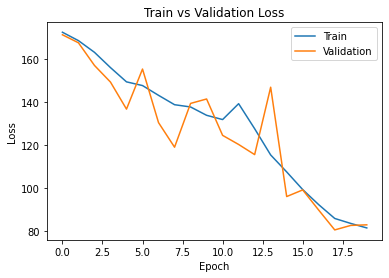

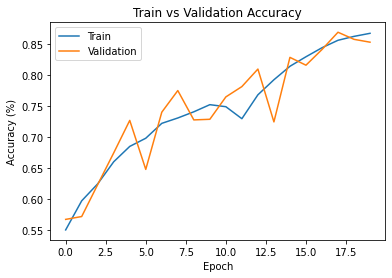

In [ ]:

plt.title("Train vs Validation Loss")
plt.plot(avg_train_loss_epoch, label="Train")
plt.plot(avg_val_loss_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

# Comparing SGD with Adam

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size), 
    GRU(embedding_size, num_hidden_units_GRU), 
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:

BATCH = batch_size
LEARNING_RATE = learning_rate
train_acc_epoch = []
avg_train_loss_epoch = []

val_acc_epoch = []
avg_val_loss_epoch = []

for epoch in range(num_epochs):
    avg_train_loss = 0 # Average training loss per batch
    avg_val_loss = 0 # Average validation loss per batch
    train_acc = 0 # Training accuracy per batch
    val_acc = 0 # Validation accuracy per batch

    # Training
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], BATCH):
        batch = train_indices[it:it+BATCH]
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
        train_prediction = eval_op(messages_train[batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
    train_acc_epoch.append(train_acc/messages_train.shape[0])
    avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

    # Validation
    val_indices = np.arange(len(messages_valid)) 
    np.random.shuffle(val_indices)    
    for it in range(0, messages_valid.shape[0], BATCH):
        batch = val_indices[it:it+BATCH]
        avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
        val_prediction = eval_op(messages_valid[batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
    val_acc_epoch.append(val_acc/messages_valid.shape[0])
    avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

    print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' 
          % (epoch + 1, avg_train_loss/messages_train.shape[0],
             avg_val_loss/messages_valid.shape[0],
             100*train_acc/messages_train.shape[0],
             100*val_acc/messages_valid.shape[0]))



Epoch 0001  Training Loss 127.51 Validation Loss 80.06 Training Accuracy 74.58 Validation Accuracy 86.00
Epoch 0002  Training Loss 75.81 Validation Loss 74.39 Training Accuracy 87.90 Validation Accuracy 87.56
Epoch 0003  Training Loss 67.82 Validation Loss 69.85 Training Accuracy 89.39 Validation Accuracy 87.78
Epoch 0004  Training Loss 63.68 Validation Loss 69.77 Training Accuracy 90.18 Validation Accuracy 88.22
Epoch 0005  Training Loss 61.07 Validation Loss 69.15 Training Accuracy 90.54 Validation Accuracy 87.88
Epoch 0006  Training Loss 59.88 Validation Loss 69.40 Training Accuracy 90.88 Validation Accuracy 88.18
Epoch 0007  Training Loss 56.17 Validation Loss 73.25 Training Accuracy 91.41 Validation Accuracy 87.50
Epoch 0008  Training Loss 54.60 Validation Loss 74.67 Training Accuracy 91.72 Validation Accuracy 87.64
Epoch 0009  Training Loss 51.30 Validation Loss 73.38 Training Accuracy 92.22 Validation Accuracy 87.58
Epoch 0010  Training Loss 49.14 Validation Loss 79.81 Training 

In [ ]:
avg_test_loss = float(loss_function(messages_test, labels_test)) * len(messages_test)
test_prediction = eval_op(messages_test).argmax(1)
test_acc = (np.array(test_prediction).flatten() == labels_test).sum() / messages_test.shape[0]

print("Final Accuracy on Test Set (ADAM):", test_acc)

Final Accuracy on Test Set (ADAM): 0.8744


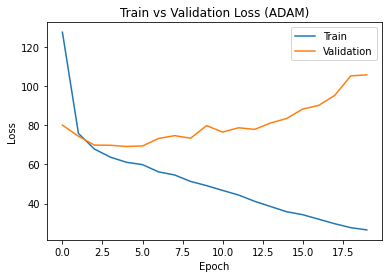

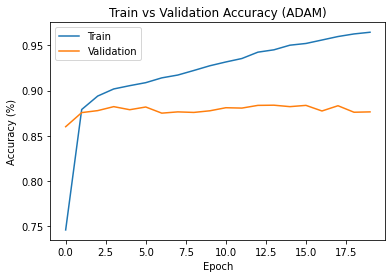

In [ ]:

plt.title("Train vs Validation Loss (ADAM)")
plt.plot(avg_train_loss_epoch, label="Train")
plt.plot(avg_val_loss_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Train vs Validation Accuracy (ADAM)")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

Explanation of how Adam optimizer works.

`Stochastic gradient descent has a learning rate for training all parameters and does not change during training. Whereas the Adam Optimizer is basically a combination of two different gradient descent methodologies, wherein the concepts of momentum and RMSP are used. Adam uses both the exponential moving average of the gradients and square gradients, such that the momentum prevents oscillation when gradient descent reaches global minimas, but takes big enough steps to get there faster and avoid local minimas.`

# Early Stopping

In [ ]:
gru_rnn3 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size), 
    GRU(embedding_size, num_hidden_units_GRU), 
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:

opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:


BATCH = batch_size
LEARNING_RATE = learning_rate
train_acc_epoch = []
avg_train_loss_epoch = []

val_acc_epoch = []
avg_val_loss_epoch = []

counter = 0
min_val_loss = 1e10
min_state = gru_rnn3


for epoch in range(num_epochs):
    if counter == max_patience_window:
        break
    
    avg_train_loss = 0 # Average training loss per batch
    avg_val_loss = 0 # Average validation loss per batch
    train_acc = 0 # Training accuracy per batch
    val_acc = 0 # Validation accuracy per batch

    # Training
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], BATCH):
        batch = train_indices[it:it+BATCH]
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
        train_prediction = eval_op(messages_train[batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
    train_acc_epoch.append(train_acc/messages_train.shape[0])
    avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

    # Validation
    val_indices = np.arange(len(messages_valid)) 
    np.random.shuffle(val_indices)    
    for it in range(0, messages_valid.shape[0], BATCH):
        batch = val_indices[it:it+BATCH]
        avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
        val_prediction = eval_op(messages_valid[batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
    val_acc_epoch.append(val_acc/messages_valid.shape[0])
    avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

    if avg_val_loss/messages_valid.shape[0] < min_val_loss:
        min_val_loss = avg_val_loss/messages_valid.shape[0]
        min_state = gru_rnn3
        min_val_acc = val_acc / messages_valid.shape[0]
        counter = 0
    elif avg_val_loss/messages_valid.shape[0] >= min_val_loss:
        counter += 1
    
    
    


    print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' 
          % (epoch + 1, avg_train_loss/messages_train.shape[0],
             avg_val_loss/messages_valid.shape[0],
             100*train_acc/messages_train.shape[0],
             100*val_acc/messages_valid.shape[0]))



Epoch 0001  Training Loss 120.59 Validation Loss 73.83 Training Accuracy 75.73 Validation Accuracy 87.42
Epoch 0002  Training Loss 72.79 Validation Loss 70.25 Training Accuracy 88.44 Validation Accuracy 87.86
Epoch 0003  Training Loss 66.37 Validation Loss 68.99 Training Accuracy 89.67 Validation Accuracy 88.22
Epoch 0004  Training Loss 63.23 Validation Loss 72.22 Training Accuracy 90.19 Validation Accuracy 87.42
Epoch 0005  Training Loss 61.18 Validation Loss 75.41 Training Accuracy 90.49 Validation Accuracy 86.82
Epoch 0006  Training Loss 59.24 Validation Loss 71.17 Training Accuracy 90.92 Validation Accuracy 87.90
Epoch 0007  Training Loss 55.92 Validation Loss 71.65 Training Accuracy 91.43 Validation Accuracy 87.90
Epoch 0008  Training Loss 54.91 Validation Loss 73.97 Training Accuracy 91.64 Validation Accuracy 87.60


In [ ]:
gru_rnn3 = min_state

avg_test_loss = float(loss_function(messages_test, labels_test)) * len(messages_test)
test_prediction = eval_op(messages_test).argmax(1)
test_acc = (np.array(test_prediction).flatten() == labels_test).sum() / messages_test.shape[0]

print("Final Accuracy on Test Set (ADAM w/ Early Stop):", test_acc)
print("Minimum Validation Accuracy (ADAM w/ Early Stop:", min_val_acc)

Final Accuracy on Test Set (ADAM w/ Early Stop): 0.8738
Minimum Validation Accuracy (ADAM w/ Early Stop: 0.8822
